In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display, Image
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 16 (Generation - Self-RAG)"

# Generation

![](images/generation.png)

# Self-RAG

![](images/16-self-rag.png)

![](images/16-self-rag-implementation.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_38647f5e19', 'id': 'chatcmpl-BQDpuUuq3GxM93181kPv9KAezyixR', 'finish_reason': 'stop', 'logprobs': None}, id='run-357964f7-f3aa-4974-9faa-d340e177cca9-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
articles = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

loader = WebBaseLoader(
    web_paths=articles,
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

3

In [9]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

In [10]:
print(docs[1].page_content[:1000])



      Prompt Engineering
    
Date: March 15, 2023  |  Estimated Reading Time: 21 min  |  Author: Lilian Weng


Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.
This post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.
[My personal spicy take] In my opinion, some prompt engineering papers are not worthy 8 pages long, since those tricks can be explained in one or a few sentences and the rest is all about benchmarking. An easy-to-use and shared benchmark infrastructure

In [11]:
print(docs[2].page_content[:1000])



      Adversarial Attacks on LLMs
    
Date: October 25, 2023  |  Estimated Reading Time: 33 min  |  Author: Lilian Weng


The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.
A large body of ground work on adversarial attacks is on images, and differently it operates in the continuous, high-dimensional space. Attacks for discrete data like text have been considered to be a lot more challenging, due to lack of direct gradient signals. My past post on Controllable Text Generation is quite relevant to this topic, as attacking LLMs is essentially to control the model to output a certain type of (unsafe) content.
There is also a branch of work on attackin

## Split documents

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [13]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
splits = text_splitter.split_documents(docs)
len(splits)

180

## Store documents

In [14]:
from langchain_core.vectorstores import InMemoryVectorStore

In [15]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(180, 180)

In [16]:
retriever = vectorstore.as_retriever()

## RAG

In [17]:
from typing import Annotated, Literal, TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.runnables import chain
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command
from pydantic import BaseModel, Field

In [18]:
retrieval_prompt_template = """You are grader assistant assessing the need to retrieve additional documents to answer the user's question.
If you are sure that all the necessary data is available, then you do not need to retrieve additional documents.
Give a binary score to indicate whether retrieval is required.

User question:
{question}
"""
print(retrieval_prompt_template)

You are grader assistant assessing the need to retrieve additional documents to answer the user's question.
If you are sure that all the necessary data is available, then you do not need to retrieve additional documents.
Give a binary score to indicate whether retrieval is required.

User question:
{question}



In [19]:
rag_prompt_template = """Answer the following question based on this context:

{context}

Question: {question}
"""
print(rag_prompt_template)

Answer the following question based on this context:

{context}

Question: {question}



In [20]:
answer_prompt_template = """Answer the following question:

Question: {question}
"""
print(answer_prompt_template)

Answer the following question:

Question: {question}



In [21]:
no_answer_prompt = "I don't have an answer to the question."
print(no_answer_prompt)

I don't have an answer to the question.


In [22]:
relevance_grading_prompt_template = """You are a grader assessing relevance of a retrieved document to a user question.
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
Give a binary score to indicate whether the document is relevant to the question.

Retrieved document:
{document}

User question:
{question}
"""

print(relevance_grading_prompt_template)

You are a grader assessing relevance of a retrieved document to a user question.
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
Give a binary score to indicate whether the document is relevant to the question.

Retrieved document:
{document}

User question:
{question}



In [23]:
hallucinations_grading_prompt_template = """You are a grader assessing whether an LLM answer is grounded in / supported by a set of retrieved facts.
Give a binary score whether the answer is grounded in / supported by the set of facts.

Set of facts:
{context}

LLM answer:
{answer}
"""

print(hallucinations_grading_prompt_template)

You are a grader assessing whether an LLM answer is grounded in / supported by a set of retrieved facts.
Give a binary score whether the answer is grounded in / supported by the set of facts.

Set of facts:
{context}

LLM answer:
{answer}



In [24]:
answer_grading_prompt_template = """You are a grader assessing whether an answer addresses / resolves a question. 
Give a binary score whether the answer resolves the question.

User question:
{question}

LLM answer:
{answer}
"""

print(answer_grading_prompt_template)

You are a grader assessing whether an answer addresses / resolves a question. 
Give a binary score whether the answer resolves the question.

User question:
{question}

LLM answer:
{answer}



In [25]:
query_rewriting_prompt_template = """You a question re-writer that converts an input question to a better version that is optimized for web search. 
Look at the input and try to reason about the underlying semantic intent / meaning.

Here is the initial question:
{question}

Formulate an improved question."""

print(query_rewriting_prompt_template)

You a question re-writer that converts an input question to a better version that is optimized for web search. 
Look at the input and try to reason about the underlying semantic intent / meaning.

Here is the initial question:
{question}

Formulate an improved question.


In [26]:
class RetrievalGrade(BaseModel):
    """Check if retrieval of additional documents is required."""
    chain_of_thought: str = Field(
        ..., description="Step by step reasoning to check if retrieval of additional documents is required"
    )
    is_required: bool = Field(
        description="Retrieval of additional documents is required"
    )

retrieval_grader_llm = llm.with_structured_output(RetrievalGrade, method="function_calling")

In [27]:
class RelevanceGrade(BaseModel):
    """Relevance check on retrieved document."""
    chain_of_thought: str = Field(
        ..., description="Step by step reasoning to check if the document is relevant to the question"
    )
    is_relevant: bool = Field(
        description="Document is relevant to the question"
    )

relevance_grader_llm = llm.with_structured_output(RelevanceGrade, method="function_calling")

@chain
def grade_document_relevance(document, question):
    relevance_grading_prompt = relevance_grading_prompt_template.format(document=document, question=question)
    response = relevance_grader_llm.invoke([HumanMessage(content=relevance_grading_prompt)])
    return response

In [28]:
class HallucationsGrade(BaseModel):
    """Hallucination check in generated answer."""
    chain_of_thought: str = Field(
        ..., description="Step by step reasoning to check if the answer is grounded in the facts"
    )
    is_grounded: bool = Field(
        description="Answer is grounded in the facts"
    )

hallucations_grader_llm = llm.with_structured_output(HallucationsGrade, method="function_calling")

In [29]:
class AnswerGrade(BaseModel):
    """Check if answer addresses the question."""
    chain_of_thought: str = Field(
        ..., description="Step by step reasoning to check if the answer addresses the questions"
    )
    is_useful: bool = Field(
        description="Answer addresses the question"
    )

answer_grader_llm = llm.with_structured_output(AnswerGrade, method="function_calling")

In [30]:
class SearchQuery(BaseModel):
    """Question optimization for search."""
    chain_of_thought: str = Field(
        ..., description="Step by step reasoning to optimize query for search"
    )
    search_query: str = Field(
        description="Optimized search query"
    )

search_llm = llm.with_structured_output(SearchQuery, method="function_calling")

In [31]:
def format_docs(docs: list[Document]) -> list[str]:
    return "\n\n".join(doc.page_content for doc in docs)

In [32]:
class State(TypedDict):
    question: str
    retrieval_grade: RetrievalGrade
    documents: list[Document]
    relevance_grades: list[RelevanceGrade]
    generation: str
    hallucinations_grade: HallucationsGrade
    context: list[Document]
    answer_grade: AnswerGrade
    answer: str

In [33]:
def grade_retrieval(state: State):
    question = state["question"]
    retrieval_prompt = retrieval_prompt_template.format(question=question)
    retrieval_grade = retrieval_grader_llm.invoke(retrieval_prompt)
    return {"retrieval_grade": retrieval_grade}


def decide_to_retrieve(state: State) -> Literal["retrieve", "generate_answer"]:
    retrieval_grade = state["retrieval_grade"]
    
    if retrieval_grade.is_required:
        return "retrieve"
    else:
        return "generate_answer"


def retrieve(state: State):
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents}


def grade_documents(state: State):
    question = state["question"]
    documents = state["documents"]

    relevance_grades = grade_document_relevance.batch(
        documents, question=question
    )
    filtered_documents = [document for (document, relevance_grade) in zip(documents, relevance_grades) if relevance_grade.is_relevant]
            
    return {"context": filtered_documents, "relevance_grades": relevance_grades}

    
def check_documents_relevance(state: State) -> Literal["generate_rag_answer", "generate_no_answer"]:
    filtered_documents = state["context"]
    
    if len(filtered_documents) > 0:
        return "generate_rag_answer"
    else:
        return "generate_no_answer"
        

def generate_rag_answer(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(
        question=state["question"],
        context=docs_content
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}


def generate_answer(state: State):
    answer_prompt = answer_prompt_template.format(
        question=state["question"]
    )
    response = llm.invoke([
        HumanMessage(content=answer_prompt)
    ])
    return {"answer": response.content}
    

def generate_no_answer(state: State):
    return {"answer": no_answer_prompt}
    

def grade_hallucinations(state: State):
    filtered_documents = state["context"]
    answer = state["answer"]
    hallucinations_grading_prompt = hallucinations_grading_prompt_template.format(
        context=filtered_documents,
        answer=answer
    )
    hallucinations_grade = hallucations_grader_llm.invoke(hallucinations_grading_prompt)
    return {"hallucinations_grade": hallucinations_grade}


def check_hallucinations(state: State) -> Literal["grade_answer", "generate_rag_answer"]:
    hallucinations_grade = state["hallucinations_grade"]
    
    if hallucinations_grade.is_grounded:
        return "grade_answer"
    else:
        return "generate_rag_answer"


def grade_answer(state: State):
    question = state["question"]
    answer = state["answer"]
    answer_grading_prompt = answer_grading_prompt_template.format(
        question=question,
        answer=answer
    )
    answer_grade = answer_grader_llm.invoke(answer_grading_prompt)
    return {"answer_grade": answer_grade}


def check_answer(state: State) -> Literal["__end__", "rewrite_query"]:
    answer_grade = state["answer_grade"]
    
    if answer_grade.is_useful:
        return END
    else:
        return "rewrite_query"


def rewrite_query(state: State):
    question = state["question"]
    query_rewriting_prompt = query_rewriting_prompt_template.format(question=question)
    response = search_llm.invoke(query_rewriting_prompt)
    return {"question": response.search_query}

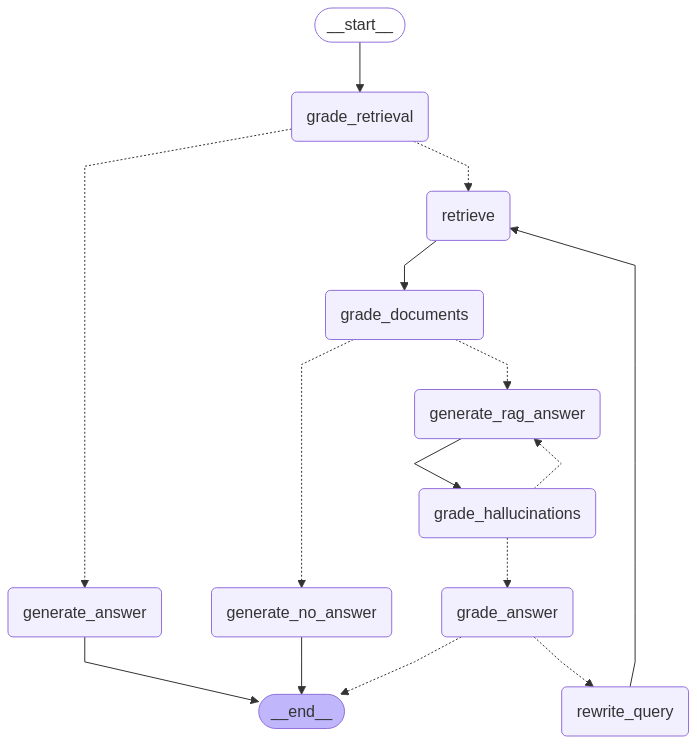

In [34]:
graph_builder = StateGraph(State)

graph_builder.add_edge(START, "grade_retrieval")
graph_builder.add_node("grade_retrieval", grade_retrieval)
graph_builder.add_conditional_edges(
    "grade_retrieval", 
    decide_to_retrieve,
    ["retrieve", "generate_answer"]
)

graph_builder.add_node("generate_answer", generate_answer)
graph_builder.add_edge("generate_answer", END)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_edge("retrieve", "grade_documents")
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_conditional_edges(
    "grade_documents", 
    check_documents_relevance,
    ["generate_rag_answer", "generate_no_answer"]
)

graph_builder.add_node("generate_rag_answer", generate_rag_answer)
graph_builder.add_edge("generate_rag_answer", "grade_hallucinations")
graph_builder.add_node("grade_hallucinations", grade_hallucinations)
graph_builder.add_conditional_edges(
    "grade_hallucinations", 
    check_hallucinations,
    ["grade_answer", "generate_rag_answer"]
)

graph_builder.add_node("generate_no_answer", generate_no_answer)
graph_builder.add_edge("generate_no_answer", END)

graph_builder.add_node("grade_answer", grade_answer)
graph_builder.add_conditional_edges(
    "grade_answer", 
    check_answer,
    ["__end__", "rewrite_query"]
)

graph_builder.add_node("rewrite_query", rewrite_query)
graph_builder.add_edge("rewrite_query", "retrieve")

graph = graph_builder.compile()
graph

In [35]:
query = "What are common types of agent memory?"

response = graph.invoke({"question": query})
rprint(response)
rprint(Markdown(response["answer"]))

{
    'question': 'What are common types of agent memory?',
    'retrieval_grade': RetrievalGrade(
        chain_of_thought='The user asks about common types of agent memory. Typically, agent memory types include 
episodic memory, semantic memory, working memory, and long-term memory, among others. These are standard concepts 
likely to be included in general knowledge or documents about agents. If the available data covers basic AI or 
agent memory types, no additional retrieval is needed. Without evidence suggesting a lack of these details, 
retrieval is not required.',
        is_required=False
    ),
    'answer': 'Common types of agent memory include:\n\n1. **Short-term memory (Working Memory):** Used to store 
information temporarily for immediate processing and decision-making. It holds recent sensory inputs or 
intermediate results.\n\n2. **Long-term memory:** Stores knowledge, experiences, and learned behaviors that the 
agent can retrieve and use over extended periods.\n\n3. **Episodic memory:** Stores specific experiences or events 
that the agent has encountered, enabling the agent to recall past states or situations.\n\n4. **Semantic memory:** 
Contains general facts, concepts, and information about the world that the agent has learned but is not tied to 
specific experiences.\n\n5. **Procedural memory:** Holds knowledge about how to perform tasks or actions, such as 
skills or routines that the agent can execute automatically.\n\nThese memory types help agents to perceive their 
environment, learn from it, and make informed decisions.'
}

Common types of agent memory include:                                                                              

 1 Short-term memory (Working Memory): Used to store information temporarily for immediate processing and          
   decision-making. It holds recent sensory inputs or intermediate results.                                        
 2 Long-term memory: Stores knowledge, experiences, and learned behaviors that the agent can retrieve and use over 
   extended periods.                                                                                               
 3 Episodic memory: Stores specific experiences or events that the agent has encountered, enabling the agent to    
   recall past states or situations.                                                                               
 4 Semantic memory: Contains general facts, concepts, and information about the world that the agent has learned   
   but is not tied to specific experiences.                                                                        
 5 Procedural memory: Holds knowledge about how to perform tasks or actions, such as skills or routines that the   
   agent can execute automatically.                                                                                

These memory types help agents to perceive their environment, learn from it, and make informed decisions.

In [36]:
query = "What are recent types of adversarial attacks in LLM?"

response = graph.invoke({"question": query})
rprint(response)
rprint(Markdown(response["answer"]))

{
    'question': 'What are recent types of adversarial attacks in LLM?',
    'retrieval_grade': RetrievalGrade(
        chain_of_thought='User is asking about recent types of adversarial attacks on large language models (LLMs).
To answer this, specific and up-to-date information about various adversarial attacks targeting LLMs is required. 
Since the question explicitly asks for recent types, this implies a need for the latest research findings or news, 
which might not be contained in default knowledge. Therefore, additional document retrieval is likely necessary to 
provide a comprehensive and current answer.',
        is_required=True
    ),
    'documents': [
        Document(
            id='699566fc-cb81-4747-bc34-a1e96753b4cc',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/'},
            page_content='Weng, Lilian. (Oct 2023). “Adversarial Attacks on LLMs”. Lil’Log. 
https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/.'
        ),
        Document(
            id='b27ccb01-34d4-4f43-8bdc-243fc00cb01f',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/'},
            page_content='Adversarial Attacks on LLMs\n    \nDate: October 25, 2023  |  Estimated Reading Time: 33 
min  |  Author: Lilian Weng'
        ),
        Document(
            id='b882f510-aed2-489e-9ad0-50f0e574ea51',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/'},
            page_content='Or\n@article{weng2023attack,\n  title   = "Adversarial Attacks on LLMs",\n  author  = 
"Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Oct",\n  url     = 
"https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"\n}\nReferences#\n[1] Madry et al. “Towards Deep 
Learning Models Resistant to Adversarial Attacks”. ICLR 2018.\n[2] Ribeiro et al. “Semantically equivalent 
adversarial rules for debugging NLP models”. ACL 2018.\n[3] Guo et al. “Gradient-based adversarial attacks against 
text transformers”. arXiv preprint arXiv:2104.13733 (2021).\n[4] Ebrahimi et al. “HotFlip: White-Box Adversarial 
Examples for Text Classification”. ACL 2018.\n[5] Wallace et al. “Universal Adversarial Triggers for Attacking and 
Analyzing NLP.” EMNLP-IJCNLP 2019. | code\n[6] Mehrabi et al. “Robust Conversational Agents against Imperceptible 
Toxicity Triggers.” NAACL 2022.'
        ),
        Document(
            id='e5967c3a-5ad9-4182-98ce-08c8fd5e7e03',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/'},
            page_content='Fig. 1. An overview of threats to LLM-based applications. (Image source: Greshake et al. 
2023)\nClassification#\nAdversarial attacks on classifiers have attracted more attention in the research community 
in the past, many in the image domain. LLMs can be used for classification too. Given an input $\\mathbf{x}$ and a 
classifier $f(.)$, we would like to find an adversarial version of the input, denoted as $\\mathbf{x}_\\text{adv}$,
with imperceptible difference from $\\mathbf{x}$, such that $f(\\mathbf{x}) \\neq 
f(\\mathbf{x}_\\text{adv})$.\nText Generation#'
        )
    ],
    'relevance_grades': [
        RelevanceGrade(
            chain_of_thought='The user question asks about recent types of adversarial attacks in large language 
models (LLMs). The document retrieved is titled "Adversarial Attacks on LLMs" and was published recently in October
2023. This document likely discusses adversarial attack methods related to LLMs, which directly matches the focus 
of the user question. Therefore, the document is relevant for answering the user question.',
            is_relevant=True
        ),
        RelevanceGrade(
            chain_of_thought="The user's question is about recent types of adversarial attacks in large language 
models (LLMs). The retrieved document's title is 'Adversarial Attacks on LLMs' and it is autho

Based on Lilian Weng’s October 2023 article “Adversarial Attacks on LLMs”, recent types of adversarial attacks on  
large language models (LLMs) can be broadly categorized as follows:                                                

 1 Adversarial attacks on classifiers:                                                                             
   These attacks attempt to slightly perturb an input text (\mathbf{x}) to produce an adversarial example          
   (\mathbf{x}\text{adv}) that causes the model’s classifier (f(.)) to change its prediction, i.e., (f(\mathbf{x}) 
   \neq f(\mathbf{x}\text{adv})), while keeping the modifications imperceptible or semantically similar to humans. 
   This category is inspired by classical adversarial attacks widely studied in image classification and adapted to
   text classification and LLMs functioning as classifiers.                                                        
 2 Gradient-based attacks:                                                                                         
   Methods that use the model gradients to guide perturbations in the text input to mislead the model outputs, such
   as the work by Guo et al. (2021) [3].                                                                           
 3 White-box attacks at the token level (e.g., HotFlip):                                                           
   White-box attacks that flip tokens based on gradient information to change the model's prediction with minimal  
   edits introduced to the text, exemplified by Ebrahimi et al. (2018) [4].                                        
 4 Universal adversarial triggers:                                                                                 
   These are input triggers—specific sequences of tokens—that, when prepended or appended to any input, can        
   consistently cause the model to produce incorrect or undesired outputs, as shown by Wallace et al. (2019) [5].  
 5 Semantically equivalent adversarial rules:                                                                      
   Creating adversarial examples by applying transformations that preserve semantic meaning but fool the model,    
   following approaches like Ribeiro et al. (2018) [2].                                                            
 6 Imperceptible or subtle toxic triggers:                                                                         
   Tiny perturbations designed to inject toxic or harmful content into otherwise safe prompts, as studied by       
   Mehrabi et al. (2022) [6].                                                                                      
 7 Attacks targeting text generation (implied but less explicitly described):                                      
   Attackers manipulate prompts or inputs to generate harmful, biased, or misleading outputs from LLMs.            

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Summary:                                                                                                           
Recent adversarial attacks on LLMs include gradient-based token perturbations, white-box token flips (HotFlip),    
universal adversarial triggers that work across inputs, semantically preserving adversarial substitutions, and     
imperceptible toxicity injections. These strategies exploit LLM vulnerabilities both in classification and         
generation tasks to cause undesired output behaviors.                                                              

For full details, see the referenced article:                                                                      
Weng, Lilian. (Oct 2023). “Adversarial Attacks on LLMs”. Lil’Log.                                                  
https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/

In [37]:
query = "How does the AlphaCodium paper work?"

response = graph.invoke({"question": query})
rprint(response)
rprint(Markdown(response["answer"]))

{
    'question': 'How does the AlphaCodium paper work?',
    'retrieval_grade': RetrievalGrade(
        chain_of_thought='The user is asking about how the AlphaCodium paper works, which likely requires detailed 
information on the methodology, approach, and findings of the AlphaCodium paper. Without the content or summary of 
the AlphaCodium paper provided in the current conversation, I do not have sufficient information to answer this 
question thoroughly. Therefore, retrieval of additional documents about the AlphaCodium paper is necessary.',
        is_required=True
    ),
    'documents': [
        Document(
            id='99f01c59-8b0f-4f77-8c5c-ebbedd234e80',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Case Studies#\nScientific Discovery Agent#\nChemCrow (Bran et al. 2023) is a 
domain-specific example in which LLM is augmented with 13 expert-designed tools to accomplish tasks across organic 
synthesis, drug discovery, and materials design. The workflow, implemented in LangChain, reflects what was 
previously described in the ReAct and MRKLs and combines CoT reasoning with tools relevant to the tasks:\n\nThe LLM
is provided with a list of tool names, descriptions of their utility, and details about the expected 
input/output.\nIt is then instructed to answer a user-given prompt using the tools provided when necessary. The 
instruction suggests the model to follow the ReAct format - Thought, Action, Action Input, Observation.'
        ),
        Document(
            id='6aeaf1d5-1c9e-4e06-828e-d381c6eb11e5',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/'},
            page_content='Effectiveness is measured by attack objective functions designed for different 
experiments:\n- In text-to-image experiment, they used Q16 (Schramowski et al. 2022) and NudeNet 
(https://github.com/notAI-tech/NudeNet).\n- text-to-text experiment: TOXIGEN\nDiversity is measured by pairwise 
dissimilarity, in form of $\\sum_{(\\mathbf{x}_i, \\mathbf{x}_j) \\in \\text{All pairs}} [1 - 
\\text{sim}(\\mathbf{x}_i, \\mathbf{x}_j)]$\nLow-toxicity is measured by Perspective API.\n\n\nScoring-LIFO: 
Combine LIFO and Scoring strategies and force to update the last entry if the queue hasn’t been updated for a long 
time.'
        ),
        Document(
            id='24a921a4-e750-4095-8a3c-57d295cece3e',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/'},
            page_content='Fig. 9. Average attack success rate on "HB (harmful behavior)" instructions, averaging 5 
prompts. Two baselines are "HB" prompt only or HB prompt followed by `"Sure here\'s"` as a suffix. "Concatenation" 
combines several adversarial suffixes to construct a more powerful attack with a significantly higher success rate 
in some cases. "Ensemble" tracks if any of 5 prompts and the concatenated one succeeded. (Image source: Zou et al. 
2023)\nARCA (“Autoregressive Randomized Coordinate Ascent”; Jones et al. 2023) considers a broader set of 
optimization problems to find input-output pairs $(\\mathbf{x}, \\mathbf{y})$ that match certain behavior pattern; 
such as non-toxic input starting with "Barack Obama" but leading to toxic output. Given an auditing objective 
$\\phi: \\mathcal{X} \\times \\mathcal{Y} \\to \\mathbb{R}$ that maps a pair of (input prompt, output completion) 
into scores. Examples of behavior patterns captured by $\\phi$ are as follows:'
        ),
        Document(
            id='c5b6d596-85f8-4a50-8842-3786b0f424b3',
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Fig. 4. Experiments on AlfWorld Env and HotpotQA. Hallucination is a more common failure 
than inefficient planning in AlfWorld. (Image source: Shinn & Labash, 2023)'
        )
    ],
    'relevance_grades': [
        RelevanceGrade(
            chain_of_thought='The us

I don't have an answer to the question.